In [1]:
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [2]:
mc_bkg = np.loadtxt('mc_background.txt')
mc_sig = np.loadtxt('mc_signal.txt')
data = np.loadtxt('LHC_data.txt')

bins = np.linspace(100, 160, 50)

bkg_counts,  bins = np.histogram(mc_bkg, bins=bins)
sig_counts,  bins = np.histogram(mc_sig, bins=bins)
data_counts, bins = np.histogram(data, bins=bins)

(0.5, 1.5)

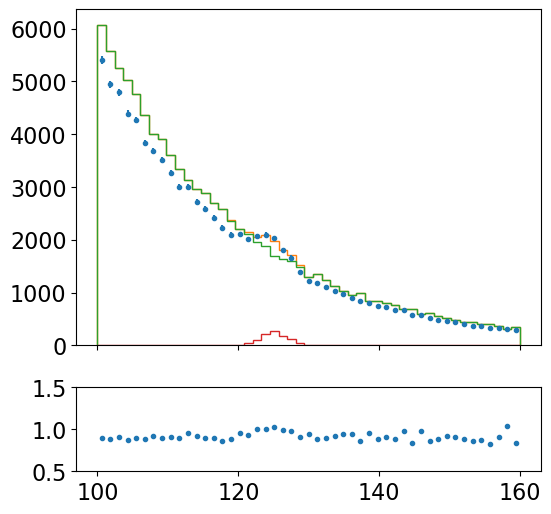

In [3]:
bin_centers = (bins[1:] + bins[:-1])/2
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]}, figsize=(6, 6))
ax1.errorbar(bin_centers, data_counts, np.sqrt(data_counts), fmt='.')
ax1.stairs(sig_counts+bkg_counts, bins)
ax1.stairs(bkg_counts, bins)
ax1.stairs(sig_counts, bins)
ratio = data_counts/(sig_counts+bkg_counts)
ax2.errorbar(bin_centers,ratio, fmt='.')
ax2.set_ylim(0.5, 1.5)

# No uncertainties on the MC or the Data/MC ration? Straight to Statistics Jail ;)

In [4]:
def negative_log_likelihood(mu, sig, bkg, data):
    '''
    -2*log(p(data|theta))
    '''
    return -2*np.sum(sp.stats.poisson.logpmf(data, mu[0]*sig+mu[1]*bkg))

# 1. Point Estimate

In [ ]:
# Allowing mu and mu_bkg to vary between 0.0 and 3.0 in 1000 steps
mu_space = np.linspace(0.0,3.0,num=1000)

# finding the best value for mu_bkg for any given mu
mu_b_hats = []
for mu_i in mu_space:
    profile_liks = []
    for mu_b_j in mu_space:
        profile_liks.append(negative_log_likelihood([mu_i,mu_b_j],sig_counts,bkg_counts,data_counts))
    mu_b_hats.append(mu_space[np.argmin(profile_liks)])

# finding the best value for mu, given the already found best values for mu_bkg
liks = []
for i in range(len(mu_space)):
    liks.append(negative_log_likelihood([mu_space[i],mu_b_hats[i]],sig_counts,bkg_counts,data_counts))

min_index = np.argmin(liks)
mu_hat = mu_space[min_index]
mu_b_hat = mu_b_hats[min_index]

print(f'mu hat = {mu_hat:.3f}')
print(f'mu bkg hat = {mu_b_hat:.3f}')

mu hat = 1.937
mu bkg hat = 0.901


In [ ]:
# The same code without profiling looks like this.
# It should find the same results in more or less the same time.

mu_space = np.linspace(0.0,3.0,num=1000)
liks = np.zeros((len(mu_space),len(mu_space)))
for i in range(len(mu_space)):
    for j in range(len(mu_space)):
        liks[i][j] = negative_log_likelihood([mu_space[i],mu_space[j]],sig_counts,bkg_counts,data_counts)


min_index = np.argmin(liks)
min_i, min_j = np.unravel_index(min_index, liks.shape)
mu_hat = mu_space[min_i]
mu_b_hat = mu_space[min_j]
print(f'mu hat = {mu_hat:.3f}')
print(f'mu bkg hat = {mu_b_hat:.3f}')

mu hat = 1.937
mu bkg hat = 0.901


## 1.1 Post Fit Plot

In [21]:
sig_counts_post = sig_counts * mu_hat
bkg_counts_post = bkg_counts * mu_b_hat

(0.5, 1.5)

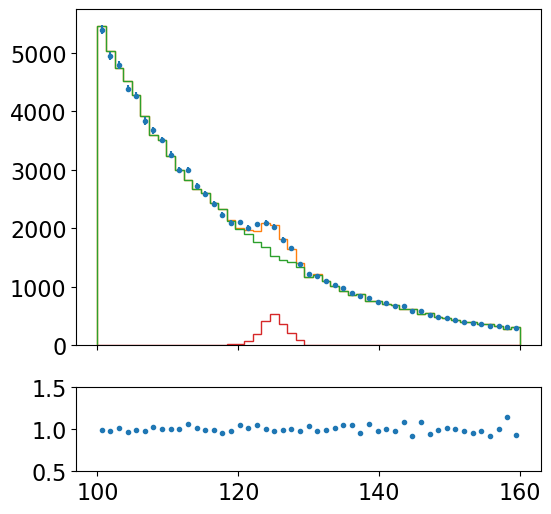

In [22]:
bin_centers = (bins[1:] + bins[:-1])/2
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]}, figsize=(6, 6))
ax1.errorbar(bin_centers, data_counts, np.sqrt(data_counts), fmt='.')
ax1.stairs(sig_counts_post+bkg_counts_post, bins)
ax1.stairs(bkg_counts_post, bins)
ax1.stairs(sig_counts_post, bins)
ratio = data_counts/(sig_counts_post+bkg_counts_post)
ax2.errorbar(bin_centers,ratio, fmt='.')
ax2.set_ylim(0.5, 1.5)

# 2. Constrained Likelihood

In [23]:
def negative_log_likelihood_constrained(mu, sig, bkg, data, mu_b_initial, sigma_b_initial):
    '''
    -2*log(p(data|theta)*gauss(mu_bkg))
    '''
    return(negative_log_likelihood(mu, sig, bkg, data)+(np.log(2*np.pi*sigma_b_initial**2)+((mu_b_initial-mu[1])/sigma_b_initial)**2))

In [24]:
mu_b_initial = 0.87
sigma_b_initial = 0.04

In [25]:
# Once you have defined your new likelihood function, the algorithm looks the same:

# finding the best value for mu_bkg for any given mu
mu_b_hats = []
for mu_i in mu_space:
    profile_liks = []
    for mu_b_j in mu_space:
        profile_liks.append(negative_log_likelihood_constrained([mu_i,mu_b_j],sig_counts,bkg_counts,data_counts, mu_b_initial, sigma_b_initial))
    mu_b_hats.append(mu_space[np.argmin(profile_liks)])

# finding the best value for mu, given the already found best values for mu_bkg
liks = []
for i in range(len(mu_space)):
    liks.append(negative_log_likelihood_constrained([mu_space[i],mu_b_hats[i]],sig_counts,bkg_counts,data_counts, mu_b_initial, sigma_b_initial))

min_index_constrained = np.argmin(liks)
mu_hat_constrained = mu_space[min_index_constrained]
mu_b_hat_constrained = mu_b_hats[min_index_constrained]

print(f'mu hat = {mu_hat_constrained:.3f}')
print(f'mu bkg hat = {mu_b_hat_constrained:.3f}')

mu hat = 1.937
mu bkg hat = 0.901


## 2.1 Post Fit Plot

In [26]:
sig_counts_post_constrained = sig_counts * mu_hat_constrained
bkg_counts_post_constrained = bkg_counts * mu_b_hat_constrained

(0.5, 1.5)

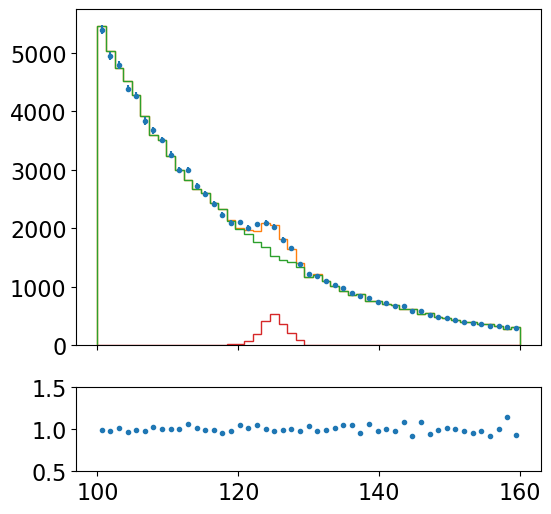

In [27]:
bin_centers = (bins[1:] + bins[:-1])/2
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]}, figsize=(6, 6))
ax1.errorbar(bin_centers, data_counts, np.sqrt(data_counts), fmt='.')
ax1.stairs(sig_counts_post_constrained+bkg_counts_post_constrained, bins)
ax1.stairs(bkg_counts_post_constrained, bins)
ax1.stairs(sig_counts_post_constrained, bins)
ratio = data_counts/(sig_counts_post_constrained+bkg_counts_post_constrained)
ax2.errorbar(bin_centers,ratio, fmt='.')
ax2.set_ylim(0.5, 1.5)

# 3. Confidence Interval

In [28]:
# Critical chi squared value for 1 degree of freedom and a p-value of 5%, and 1, 3, and 5 sigma confidence intervals
chi_sq_crit_5p = 3.84
chi_sq_crit_1sig = 1.0
chi_sq_crit_3sig = 7.82
chi_sq_crit_5sig = 23.92

minlik=np.min(liks)

(1.1369369369369369, 2.736936936936937)

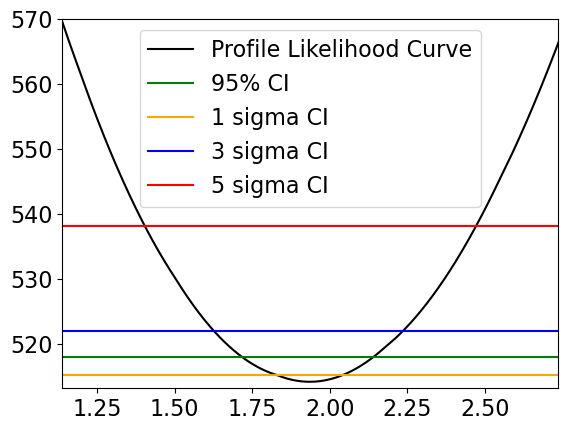

In [29]:
# Plotting the profile likelihood curve
plt.plot(mu_space, liks, color='black', label='Profile Likelihood Curve')
plt.axhline(y=minlik+chi_sq_crit_5p, color='green', label='95% CI')
plt.axhline(y=minlik+chi_sq_crit_1sig, color='orange', label='1 sigma CI')
plt.axhline(y=minlik+chi_sq_crit_3sig, color='blue', label='3 sigma CI')
plt.axhline(y=minlik+chi_sq_crit_5sig, color='red', label='5 sigma CI')
plt.legend()
ax = plt.gca()
ax.set_ylim(minlik-1,570)
ax.set_xlim(mu_hat_constrained-0.8,mu_hat_constrained+0.8)

In [30]:
def find_intersection_points(x, likelihood, level):
    diffs = likelihood - level
    sign_changes = np.where(np.diff(np.sign(diffs)))[0]  # Find where sign changes
    if len(sign_changes) < 2:
        raise ValueError("Less than two intersection points found!")
    return x[sign_changes[0]], x[sign_changes[1]]

intersections_5p = find_intersection_points(mu_space, liks, minlik+chi_sq_crit_5p)
intersections_1sig = find_intersection_points(mu_space, liks, minlik+chi_sq_crit_1sig)
intersections_3sig = find_intersection_points(mu_space, liks, minlik+chi_sq_crit_3sig)
intersections_5sig = find_intersection_points(mu_space, liks, minlik+chi_sq_crit_5sig)
downward_uncertainty_5p = mu_hat_constrained-intersections_5p[0]
upward_uncertainty_5p = intersections_5p[1] - mu_hat_constrained
downward_uncertainty_1sig = mu_hat_constrained-intersections_1sig[0]
upward_uncertainty_1sig = intersections_1sig[1] - mu_hat_constrained
downward_uncertainty_3sig = mu_hat_constrained-intersections_3sig[0]
upward_uncertainty_3sig = intersections_3sig[1] - mu_hat_constrained
downward_uncertainty_5sig = mu_hat_constrained-intersections_5sig[0]
upward_uncertainty_5sig = intersections_5sig[1] - mu_hat_constrained

In [34]:
# checking if the confidence interval is symmetric (which is expected)
if (abs(downward_uncertainty_5p-upward_uncertainty_5p)<=0.01):
    print(f'95% CI: {mu_hat_constrained:.2f} \u00B1 {downward_uncertainty_5p:.2f}')
else:
    print(f'95% CI: {mu_hat_constrained:.2f} + {upward_uncertainty_5p:.2f} - {downward_uncertainty_5p:.2f}')

if (abs(downward_uncertainty_1sig-upward_uncertainty_1sig)<=0.01):
    print(f'1 sigma CI: {mu_hat_constrained:.2f} \u00B1 {downward_uncertainty_1sig:.2f}')
else:
    print(f'1 sigma CI: {mu_hat_constrained:.2f} + {upward_uncertainty_1sig:.2f} - {downward_uncertainty_1sig:.2f}')

if (abs(downward_uncertainty_3sig-upward_uncertainty_3sig)<=0.01):
    print(f'3 sigma CI: {mu_hat_constrained:.2f} \u00B1 {downward_uncertainty_3sig:.2f}')
else:
    print(f'3 sigma CI: {mu_hat_constrained:.2f} + {upward_uncertainty_3sig:.2f} - {downward_uncertainty_3sig:.2f}')

if (abs(downward_uncertainty_5sig-upward_uncertainty_5sig)<=0.01):
    print(f'5 sigma CI: {mu_hat_constrained:.2f} \u00B1 {downward_uncertainty_5sig:.2f}')
else:
    print(f'5 sigma CI: {mu_hat_constrained:.2f} + {upward_uncertainty_5sig:.2f} - {downward_uncertainty_5sig:.2f}')

95% CI: 1.94 + 0.20 - 0.22
1 sigma CI: 1.94 ± 0.11
3 sigma CI: 1.94 + 0.30 - 0.31
5 sigma CI: 1.94 ± 0.53


# Bonus: Comparison to Minuit

In [32]:
from iminuit import Minuit

In [19]:
nll = lambda mu, mu_bkg: negative_log_likelihood_constrained([mu, mu_bkg], sig_counts, bkg_counts, data_counts, mu_b_initial, sigma_b_initial)
m = Minuit(nll, 1,1, name=(r'mu', r'mu_bkg'))
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 514.1                      │              Nfcn = 43               │
│ EDM = 2.99e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu     │   1.93    │   0.11    │            │            │         │         │       │
│ 1 │ mu_bkg │  0.9015   │  0.0032   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │        mu    mu_bkg │
├────────┼─────────────────────┤
│     mu │    0.0119 -0.105e-3 │
│ mu_bkg │ -0.105e-3  1.05e-05 │
└────────┴─────────────────────┘